In [431]:
import pandas as pd
import seaborn as sns
from datetime import datetime,date
import matplotlib.pyplot as plt
import pyecharts.options as opts
from pyecharts.charts import Bar, Line
%matplotlib inline

In [114]:
data=pd.read_excel('/Users/rickie/Desktop/czbank_test/RFM_data.xlsx')
data.head()

,品牌名称,买家昵称,付款日期,订单状态,实付金额,邮费,省份,城市,购买数量
0,数据不吹牛,叫我李2,2019-01-01 00:17:59,交易成功,186,6,上海,上海市,1
1,数据不吹牛,0cyb1992,2019-01-01 00:59:54,交易成功,145,0,广东省,广州市,1
2,数据不吹牛,萝污萌莉,2019-01-01 07:48:48,交易成功,194,8,山东省,东营市,1
3,数据不吹牛,atblovemyy,2019-01-01 09:15:49,付款以后用户退款成功，交易自动关闭,84,0,江苏省,镇江市,1
4,数据不吹牛,小星期鱼,2019-01-01 09:59:33,付款以后用户退款成功，交易自动关闭,74,0,上海,上海市,1


In [115]:
data['订单状态'].unique()

array(['交易成功', '付款以后用户退款成功，交易自动关闭'], dtype=object)

In [116]:
data=data[data['订单状态']=='交易成功']
data=data[['买家昵称','付款日期','实付金额']]
data.columns=['买家昵称','付款时间','实付金额']
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27793 entries, 0 to 28832
Data columns (total 3 columns):
买家昵称    27793 non-null object
付款时间    27793 non-null datetime64[ns]
实付金额    27793 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 868.5+ KB


In [119]:
data['付款日期']=data['付款时间'].map(lambda x:x.strftime('%Y-%m-%d'))
data.head()

,买家昵称,付款时间,实付金额,付款日期
0,叫我李2,2019-01-01 00:17:59,186,2019-01-01
1,0cyb1992,2019-01-01 00:59:54,145,2019-01-01
2,萝污萌莉,2019-01-01 07:48:48,194,2019-01-01
5,重碎叠,2019-01-01 10:00:07,197,2019-01-01
6,iho_jann,2019-01-01 10:00:08,168,2019-01-01


In [192]:
#计算recency
r=data.groupby('买家昵称')['付款时间'].max().reset_index()
now=pd.to_datetime(datetime.now(),format='%Y-%m-%d %H:%M:%S')
r['R']=(now-r['付款时间']).dt.days
# date_diff=pd.to_datetime('2019-12-19')-data.groupby('买家昵称')['付款时间'].max()
# date_diff=date_diff.map(lambda x:x.days)
r=r[['买家昵称','R']]

In [173]:
# 计算Frequency
f=data.groupby('买家昵称')['付款日期'].count().reset_index()
f.columns=['买家昵称','F']
f.head()

,买家昵称,F
0,.blue_ram,1
1,.christiny,1
2,.willn1,1
3,.托托m,1
4,0000妮,1


In [193]:
#计算Monetary
m=data.groupby('买家昵称')['实付金额'].sum().reset_index()
t=m.merge(f,on='买家昵称')
t['M']=t['实付金额']/t['F']
t=t[['买家昵称','F','M']]

In [196]:
model=r.merge(t,on='买家昵称')
model.head()

,买家昵称,R,F,M
0,.blue_ram,317,1,49.0
1,.christiny,323,1,183.0
2,.willn1,342,1,34.0
3,.托托m,342,1,37.0
4,0000妮,173,1,164.0


In [203]:
model.M.describe()

count    25420.000000
mean       126.274135
std         69.055329
min         30.000000
25%         73.000000
50%        117.000000
75%        176.000000
max       2323.500000
Name: M, dtype: float64

In [218]:
model['R_score']=pd.cut(model.R,bins=[0,30,60,90,120,10000],labels=[5,4,3,2,1],right=False)
model['F_score']=pd.cut(model.F,bins=[1,2,3,4,5,100],labels=[1,2,3,4,5],right=False)
model['M_score']=pd.cut(model.M,bins=[0,50,100,150,200,10000],labels=[1,2,3,4,5],right=False)
model['R>mean']=(model['R']>=model['R'].mean())*1
model['M>mean']=(model['M']>=model['M'].mean())*1
model['F>mean']=(model['F']>=model['F'].mean())*1
model['score']=model['R>mean']*100+model['M>mean']*10+model['F>mean']*1
model.head()

,买家昵称,R,F,M,R_score,F_score,M_score,R>mean,M>mean,F>mean,score
0,.blue_ram,317,1,49.0,1,1,1,1,0,0,100
1,.christiny,323,1,183.0,1,1,4,1,1,0,110
2,.willn1,342,1,34.0,1,1,1,1,0,0,100
3,.托托m,342,1,37.0,1,1,1,1,0,0,100
4,0000妮,173,1,164.0,1,1,4,0,1,0,10


In [229]:
def cust_label(x):
    if   x== 111 :
        return '重要价值客户'
    elif x== 110 :
        return '消费潜力客户'
    elif x== 101 :
        return '频次深耕客户'
    elif x== 100 :
        return'新客户'
    elif x==  11 :
        return '重要价值流失预警客户'
    elif x==  10 :
        return'一般客户'
    elif x==   1 :
        return'高消费唤回客户'
    elif x==   0 :
        return'流失客户'
model['label']=model['score'].map(cust_label)
model['total_value']=model['F']*model['M']
model.head()

,买家昵称,R,F,M,R_score,F_score,M_score,R>mean,M>mean,F>mean,score,label,total_value
0,.blue_ram,317,1,49.0,1,1,1,1,0,0,100,新客户,49.0
1,.christiny,323,1,183.0,1,1,4,1,1,0,110,消费潜力客户,183.0
2,.willn1,342,1,34.0,1,1,1,1,0,0,100,新客户,34.0
3,.托托m,342,1,37.0,1,1,1,1,0,0,100,新客户,37.0
4,0000妮,173,1,164.0,1,1,4,0,1,0,10,一般客户,164.0


In [247]:
cnt=model['label'].value_counts().reset_index()
cnt.columns=['label','cnt']
cnt['pct']=cnt['cnt']/cnt['cnt'].sum()
cnt

,label,cnt,pct
0,新客户,7334,0.288513
1,消费潜力客户,5588,0.219827
2,流失客户,5463,0.214910
3,一般客户,4982,0.195987
4,高消费唤回客户,704,0.027695
5,重要价值流失预警客户,654,0.025728
6,频次深耕客户,367,0.014437
7,重要价值客户,328,0.012903


In [252]:
value=model.groupby('label').total_value.sum().reset_index()
value['v_pct']=value['total_value']/value['total_value'].sum()
p_model=value.merge(cnt,on='label')
p_model

,label,total_value,v_pct,cnt,pct
0,一般客户,946072.0,0.269436,4982,0.195987
1,新客户,534506.0,0.152224,7334,0.288513
2,流失客户,401767.0,0.114421,5463,0.214910
3,消费潜力客户,1070906.0,0.304988,5588,0.219827
4,重要价值客户,114907.0,0.032725,328,0.012903
5,重要价值流失预警客户,255313.0,0.072712,654,0.025728
6,频次深耕客户,64671.0,0.018418,367,0.014437
7,高消费唤回客户,123163.0,0.035076,704,0.027695


/Users/rickie/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


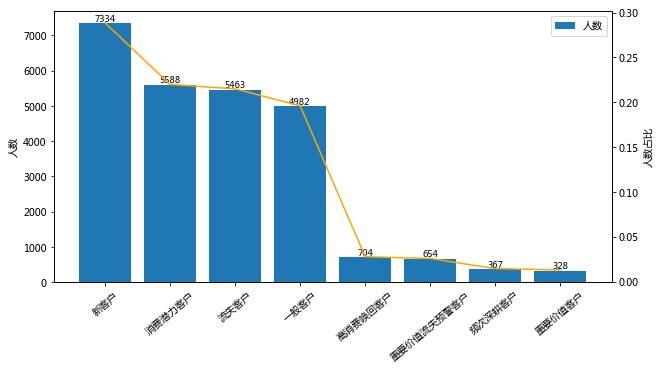

In [411]:
p_model=p_model.sort_values(by='cnt',ascending=False)

fig,ax=plt.subplots(1,1,figsize=(10,5))
ax.bar(p_model['label'],p_model['cnt'],label='人数')
ax.set_ylabel('人数')
plt.legend(loc='best')
plt.xticks(rotation=40,fontsize=10)
for a,b in zip(p_model['label'],p_model['cnt']):
    plt.text(a, b+0.001, b, ha='center', va= 'bottom',fontsize=9)

ax1=ax.twinx()#共享x轴
ax1.plot(p_model['label'],p_model['pct'],color='orange')
ax1.set_ylabel('人数占比')
fig.show()

In [439]:

y_data=list(p_model['cnt'].values)

y_data2=[0.2885129819040126,
 0.2198269079464988,
 0.21490952006294256,
 0.1959874114870181,
 0.027694728560188828,
 0.025727773406766324,
 0.014437450826121164,
 0.012903225806451613]
bar=(
    Bar(init_opts=opts.InitOpts(width="800px", height="400px"))
    .add_xaxis(xaxis_data=list(p_model['label'].values))
    .add_yaxis(
        series_name="人数", yaxis_data=[7334, 5588, 5463, 4982, 704, 654, 367, 328]
         , label_opts=opts.LabelOpts(is_show=True)
    )
    #建立另一个y轴
    .extend_axis(
        yaxis=opts.AxisOpts(
            name="占比",
            type_="value",
            min_=0,
            max_=0.35,
            interval=0.1,
            axislabel_opts=opts.LabelOpts(formatter="{value}% "),
        )
    )
     .set_global_opts(
         tooltip_opts=opts.TooltipOpts(
            is_show=True, trigger="axis", axis_pointer_type="cross"),
#          title_opts=opts.TitleOpts(title="人数"),
         yaxis_opts=opts.AxisOpts(name="人数"), 
         xaxis_opts=opts.AxisOpts(type_="category",
             axislabel_opts=opts.LabelOpts(rotate=25),
                                  
                             ),#设置x轴标签旋转角度
         )
)

line = (
    Line(init_opts=opts.InitOpts(width="600px", height="400px"))
    .add_xaxis(xaxis_data=list(p_model['label'].values))
    .add_yaxis(
        series_name="人数占比",
        yaxis_index=1,#y轴编号
        y_axis=y_data2,
        label_opts=opts.LabelOpts(is_show=False),
        )
    )
# bar.overlap(line).render("mixed.html")
# from pyecharts.globals import CurrentConfig, NotebookType
# CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_NOTEBOOK
bar.overlap(line).render_notebook()
